In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Ajuster les options d'affichage
pd.set_option('display.max_columns', None)  # Aucune limite sur le nombre de colonnes affichées
pd.set_option('display.max_colwidth', None)  # Aucune limite sur la largeur du contenu de la colonne

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Correctly specifying your file path
# path_global_5s_train = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Global/train_global_recording_chunks.csv"
# path_global_5s_test = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Global/test_global_recording_chunks.csv"
# path_global_5s_val = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Global/val_global_recording_chunks.csv"

path_global_5s_train = "drive/MyDrive/Dataset5sec/CSVs morceaux audio 5s/Audible/train_audible_recording_chunks.csv"
path_global_5s_test = "drive/MyDrive/Dataset5sec/CSVs morceaux audio 5s/Audible/test_audible_recording_chunks.csv"
path_global_5s_val = "drive/MyDrive/Dataset5sec/CSVs morceaux audio 5s/Audible/val_audible_recording_chunks.csv"

# Using pandas to read the CSV file into a DataFrame
df_train = pd.read_csv(path_global_5s_train)
df_test = pd.read_csv(path_global_5s_test)
df_val = pd.read_csv(path_global_5s_val)

In [46]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df_train['label'])

label_encoder_category = LabelEncoder()
label_encoder_category.fit(df_train['label_category'])

label_encoder_soundtype = LabelEncoder()
label_encoder_soundtype.fit(df_train['sound_type'])

def clean_data(df):
    y = df['label']
    y_category = df['label_category']
    y_soundtype = df['sound_type']
    y_kingdom = df['label_kingdom']
    y_class = df['label_class']
    y_order = df['label_order']
    y_family = df['label_family']
    y_subfamily = df['label_subfamily']

    # Convertir les étiquettes en nombres
    y_label_encoded = label_encoder.transform(y)
    y_category_encoded = label_encoder_category.transform(y_category)
    y_soundtype_encoded = label_encoder_soundtype.transform(y_soundtype)

    """df = df.drop(['label', 'recording_chunk_id', 'recording_id', 'annotation_chunk_id',
                  'sound_type', 'label_category', 'label_kingdom', 'label_class',
                  'label_order', 'label_family', 'label_subfamily', 'confidence_level',
                  'vocalization_type', 'code_n_ind', 'annotation_duration_prior_to_split',
                  'code_unique', 'categorie', 'ordre', 'espece', 'auteur', 'operateur',
                  'avis_operateur', 'validateur', 'espece_validee', 'permis_utilisation',
                  'date', 'GPS', 'nb_chanteurs', 'autres_especes_nb', 'autres_especes_annotees',
                  'bruits_anthropiques', 'bruits_geophoniques', 'bruit_de_fond', 'enregistreur',
                  'micro', 'bonnette', 'expansion_de_temps', 'localisation', 'annotation',
                  'annotation_exhaustive', 'photo', 'stereo', 'notes', 'annotation_initial_time',
                  'annotation_final_time', 'chunk_initial_time', 'chunk_final_time', 'sampling_rate',
                  'BPS'], axis=1)

    df = df.select_dtypes(['number'])"""
    
    df['duree'] = df['duree_min'] * 60 + df['duree_sec']
    df = df[['max_frequency', 'min_frequency', 'avg_frequency', 'duree']]
    df['min_frequency'] = df['min_frequency'].astype(int)
    df['max_frequency'] = df['max_frequency'].astype(int)

    # Gestion des valeurs manquantes
    #df.fillna(df.mean(), inplace=True)
    df = df.dropna()

    # Gestion des variables catégorielles
    df = pd.get_dummies(df)

    X = df

    return X, y_label_encoded, y_soundtype_encoded, y_category_encoded

X_train, y_train_label, y_train_soundtype, y_train_category = clean_data(df_train)
X_test, y_test_label, y_test_soundtype, y_test_category = clean_data(df_test)
X_val, y_val_label, y_val_soundtype, y_val_category = clean_data(df_val)

Évaluation LightGBM :
Accuracy sur l'ensemble de validation: 0.11951909476661952
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00        10
           2       0.06      1.00      0.12         4
           3       0.06      1.00      0.11        22
           4       0.08      0.03      0.04        38
           5       0.04      0.12      0.06         8
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00        10
           9       1.00      1.00      1.00         5
          10       0.00      0.00      0.00        23
          11       0.06      0.14      0.09         7
          12       0.00      0.00      0.00        25
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00        15
          15       0.57      0.20      0.30        20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


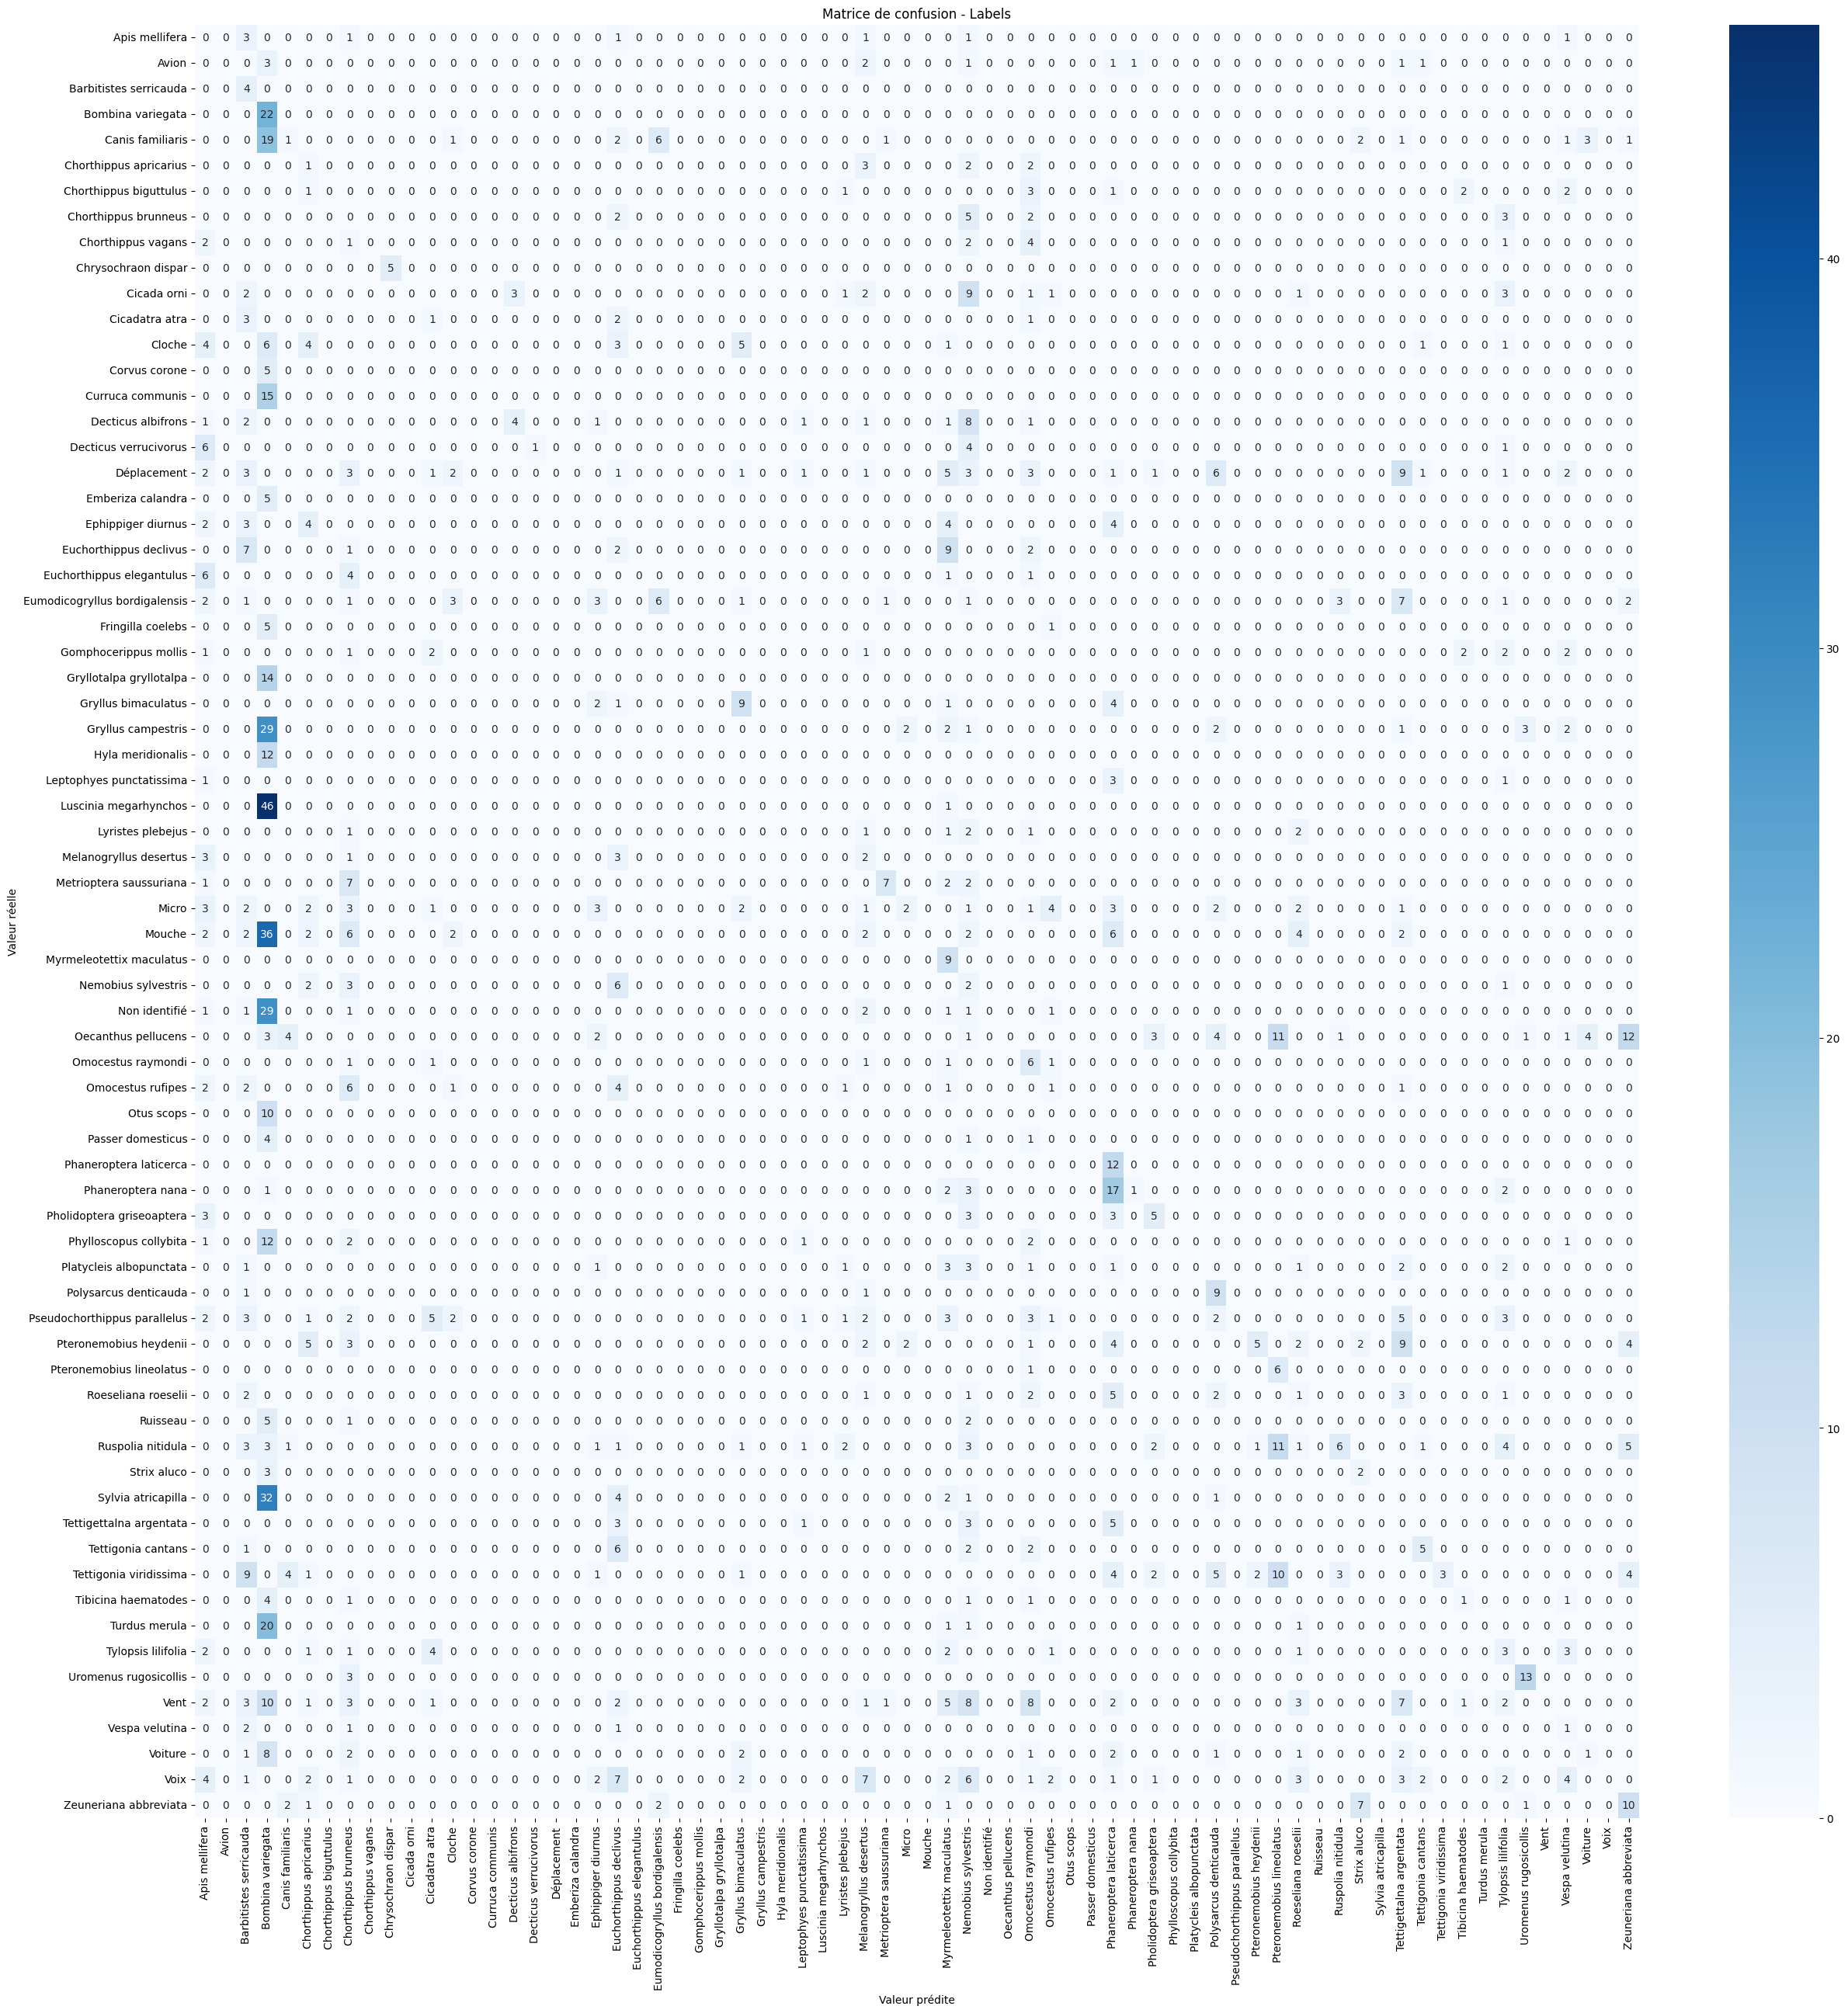

In [47]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

################# LABELS #########################################

# Initialiser et entraîner le modèle XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=2)

# Calculer les poids des classes
# 'balanced' ajuste automatiquement les poids inversément proportionnels aux fréquences des classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_label), y=y_train_label)

# Créer un dictionnaire des poids pour faciliter l'application des poids aux échantillons
weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Appliquer les poids aux instances de formation
sample_weight = np.array([weights_dict[y] for y in y_train_label])

# Entraînement du modèle avec les poids des instances
xgb_model.fit(X_train, y_train_label, sample_weight=sample_weight)

predictions_label = xgb_model.predict(X_test)

# Évaluation LightGBM
print("Évaluation LightGBM :")
print("Accuracy sur l'ensemble de validation:", accuracy_score(y_test_label, predictions_label))
print(classification_report(y_test_label, predictions_label))

# matrice de confusion
cm = confusion_matrix(y_test_label, predictions_label)
y_test_inversed = label_encoder.inverse_transform(y_test_label)

unique_labels = np.unique(y_test_inversed)

plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Matrice de confusion - Labels')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.show()

Évaluation LightGBM :
Accuracy sur l'ensemble de validation sound type: 0.4695898161244696
              precision    recall  f1-score   support

           0       0.88      0.43      0.58      1040
           1       0.04      0.93      0.07        14
           2       0.37      0.55      0.44       360

    accuracy                           0.47      1414
   macro avg       0.43      0.64      0.36      1414
weighted avg       0.74      0.47      0.54      1414



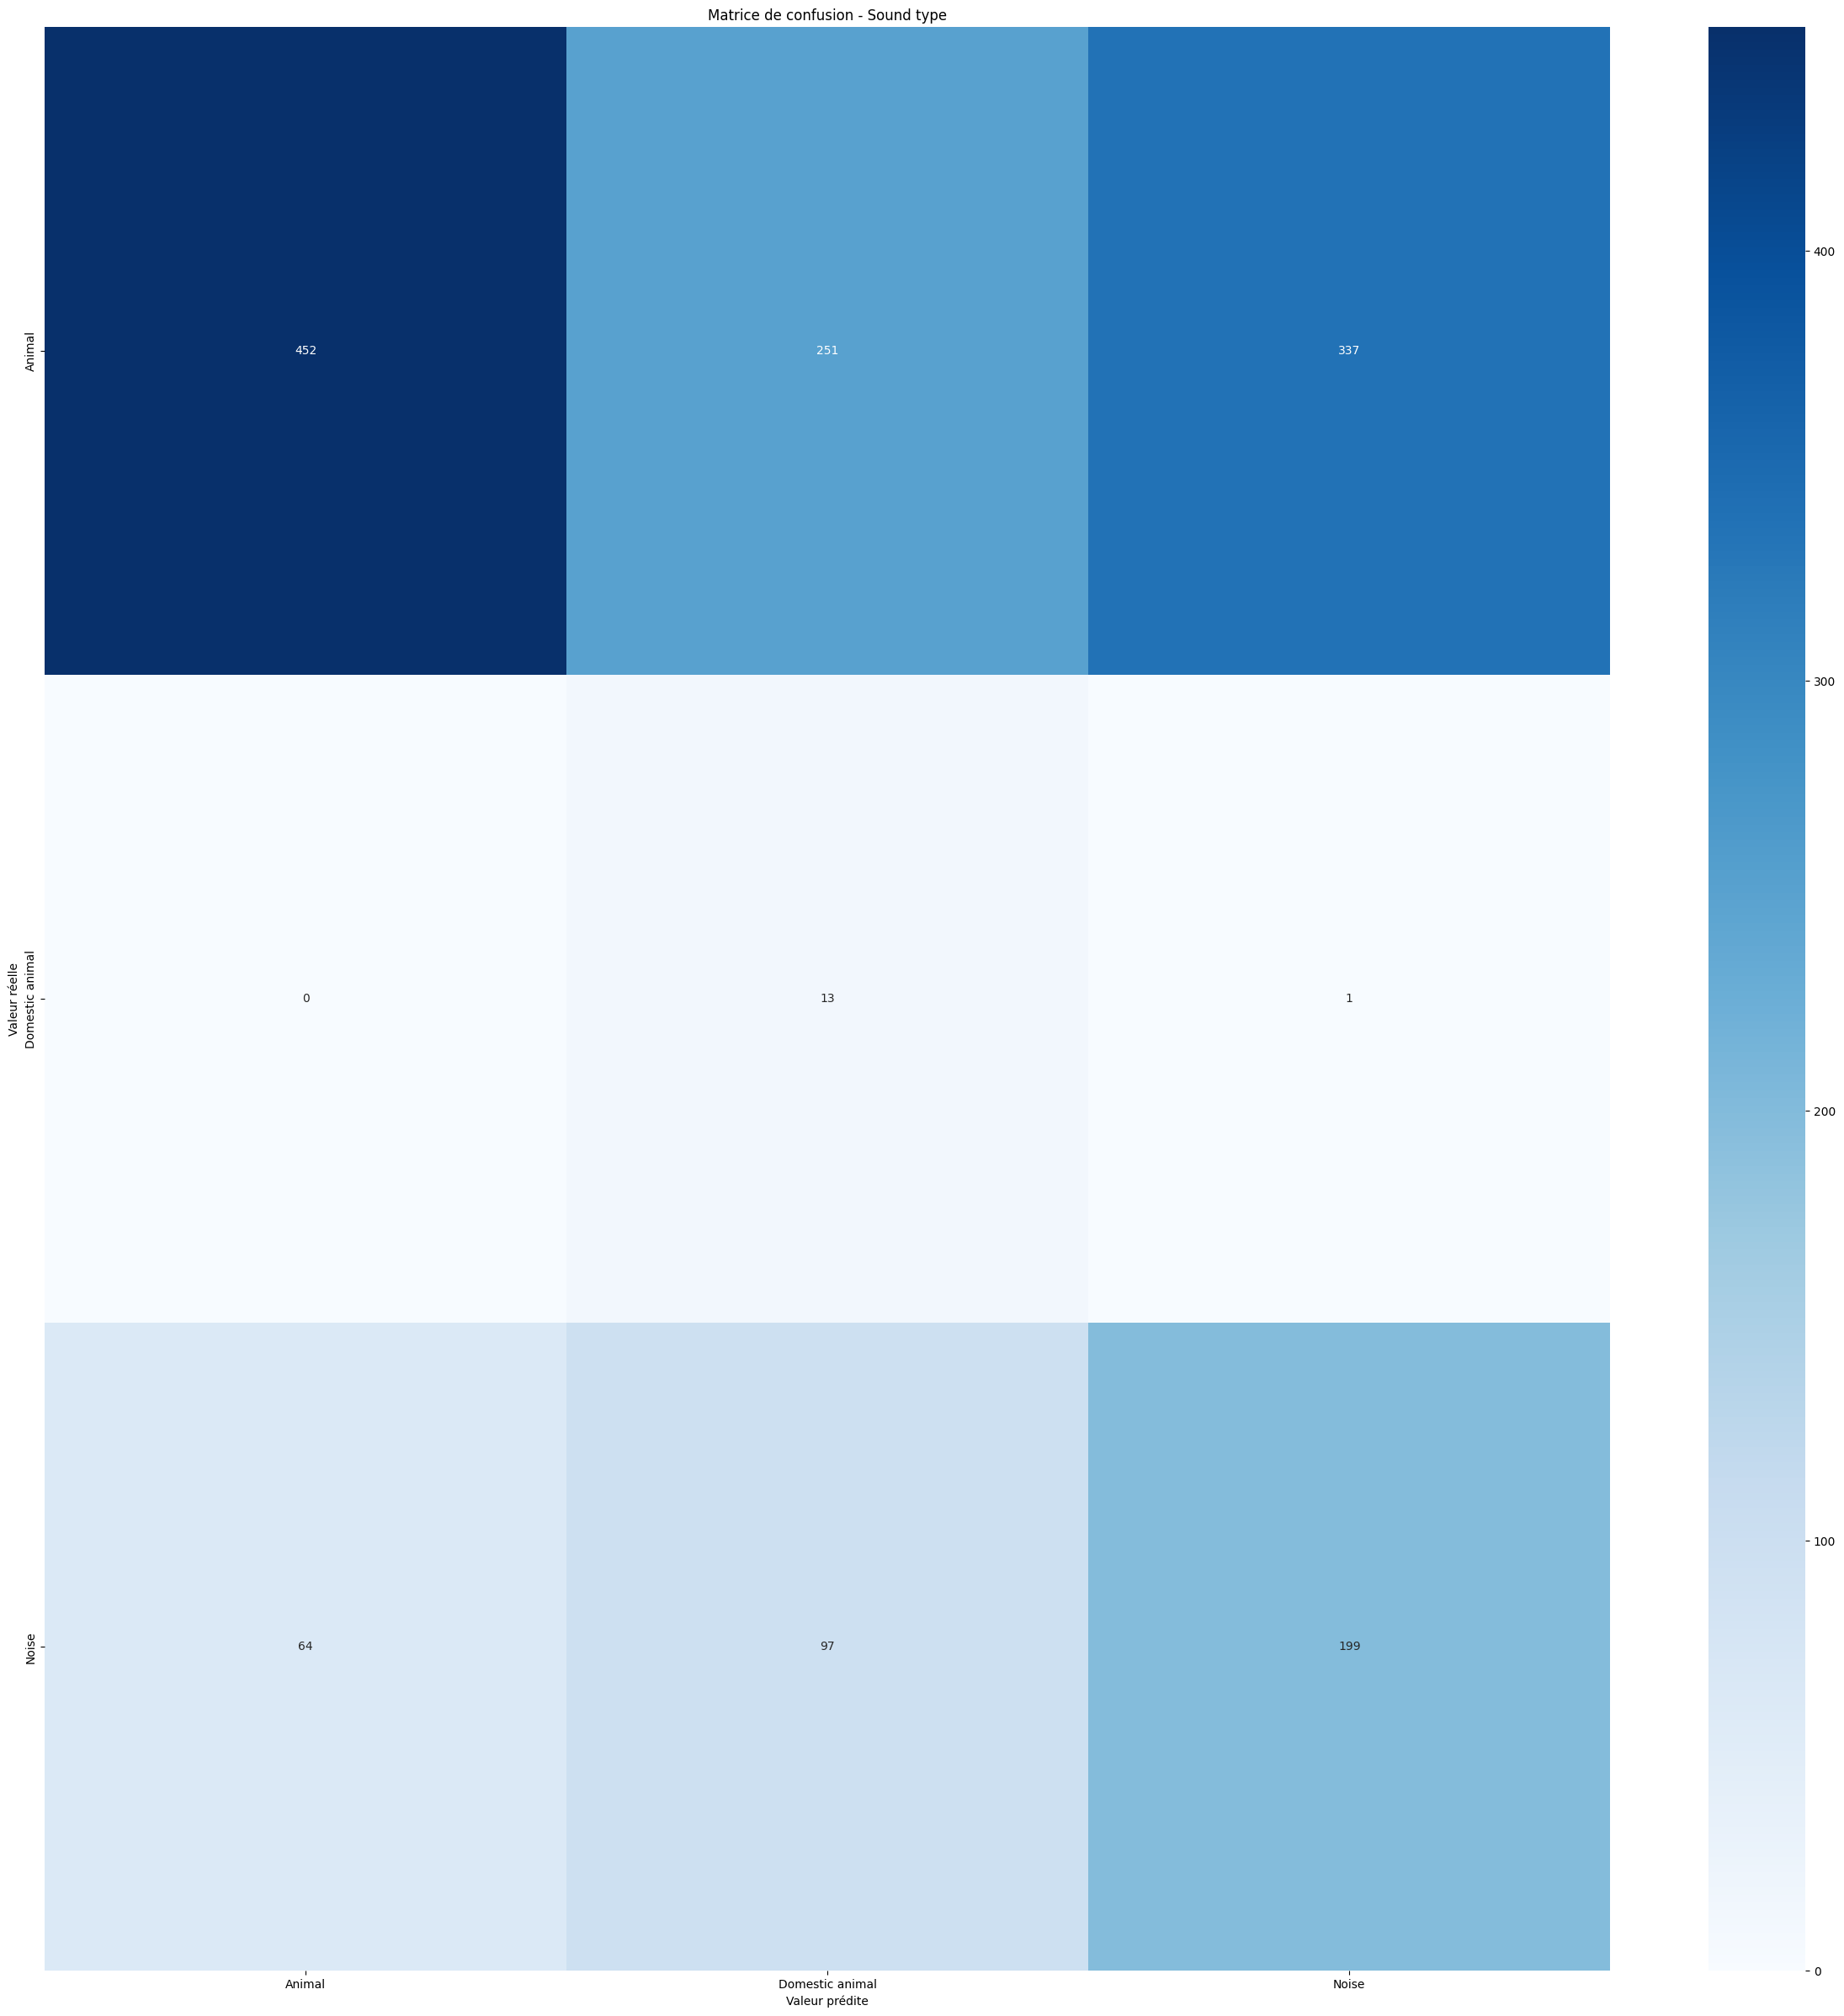

In [48]:
############################### Soundtype #################################

# Initialiser et entraîner le modèle XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=2)

# Calculer les poids des classes
# 'balanced' ajuste automatiquement les poids inversément proportionnels aux fréquences des classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_soundtype), y=y_train_soundtype)

# Créer un dictionnaire des poids pour faciliter l'application des poids aux échantillons
weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Appliquer les poids aux instances de formation
sample_weight = np.array([weights_dict[y] for y in y_train_soundtype])

# Entraînement du modèle avec les poids des instances
xgb_model.fit(X_train, y_train_soundtype, sample_weight=sample_weight)

predictions_soundtype = xgb_model.predict(X_test)

# Évaluation LightGBM
print("Évaluation LightGBM :")
print("Accuracy sur l'ensemble de validation sound type:", accuracy_score(y_test_soundtype, predictions_soundtype))
print(classification_report(y_test_soundtype, predictions_soundtype))

# matrice de confusion
cm = confusion_matrix(y_test_soundtype, predictions_soundtype)
y_test_inversed = label_encoder_soundtype.inverse_transform(y_test_soundtype)

unique_labels = np.unique(y_test_inversed)

plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Matrice de confusion - Sound type')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.show()

Évaluation LightGBM :
Accuracy sur l'ensemble de validation Category: 0.20297029702970298
              precision    recall  f1-score   support

           0       0.31      0.12      0.18       226
           1       0.09      1.00      0.17        34
           2       0.00      0.00      0.00       181
           3       0.00      0.00      0.00        66
           4       0.08      0.25      0.12        68
           5       0.12      0.58      0.20        59
           6       0.04      0.77      0.08        13
           7       0.17      0.34      0.22        38
           8       0.93      0.21      0.34       729

    accuracy                           0.20      1414
   macro avg       0.19      0.36      0.15      1414
weighted avg       0.54      0.20      0.23      1414



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


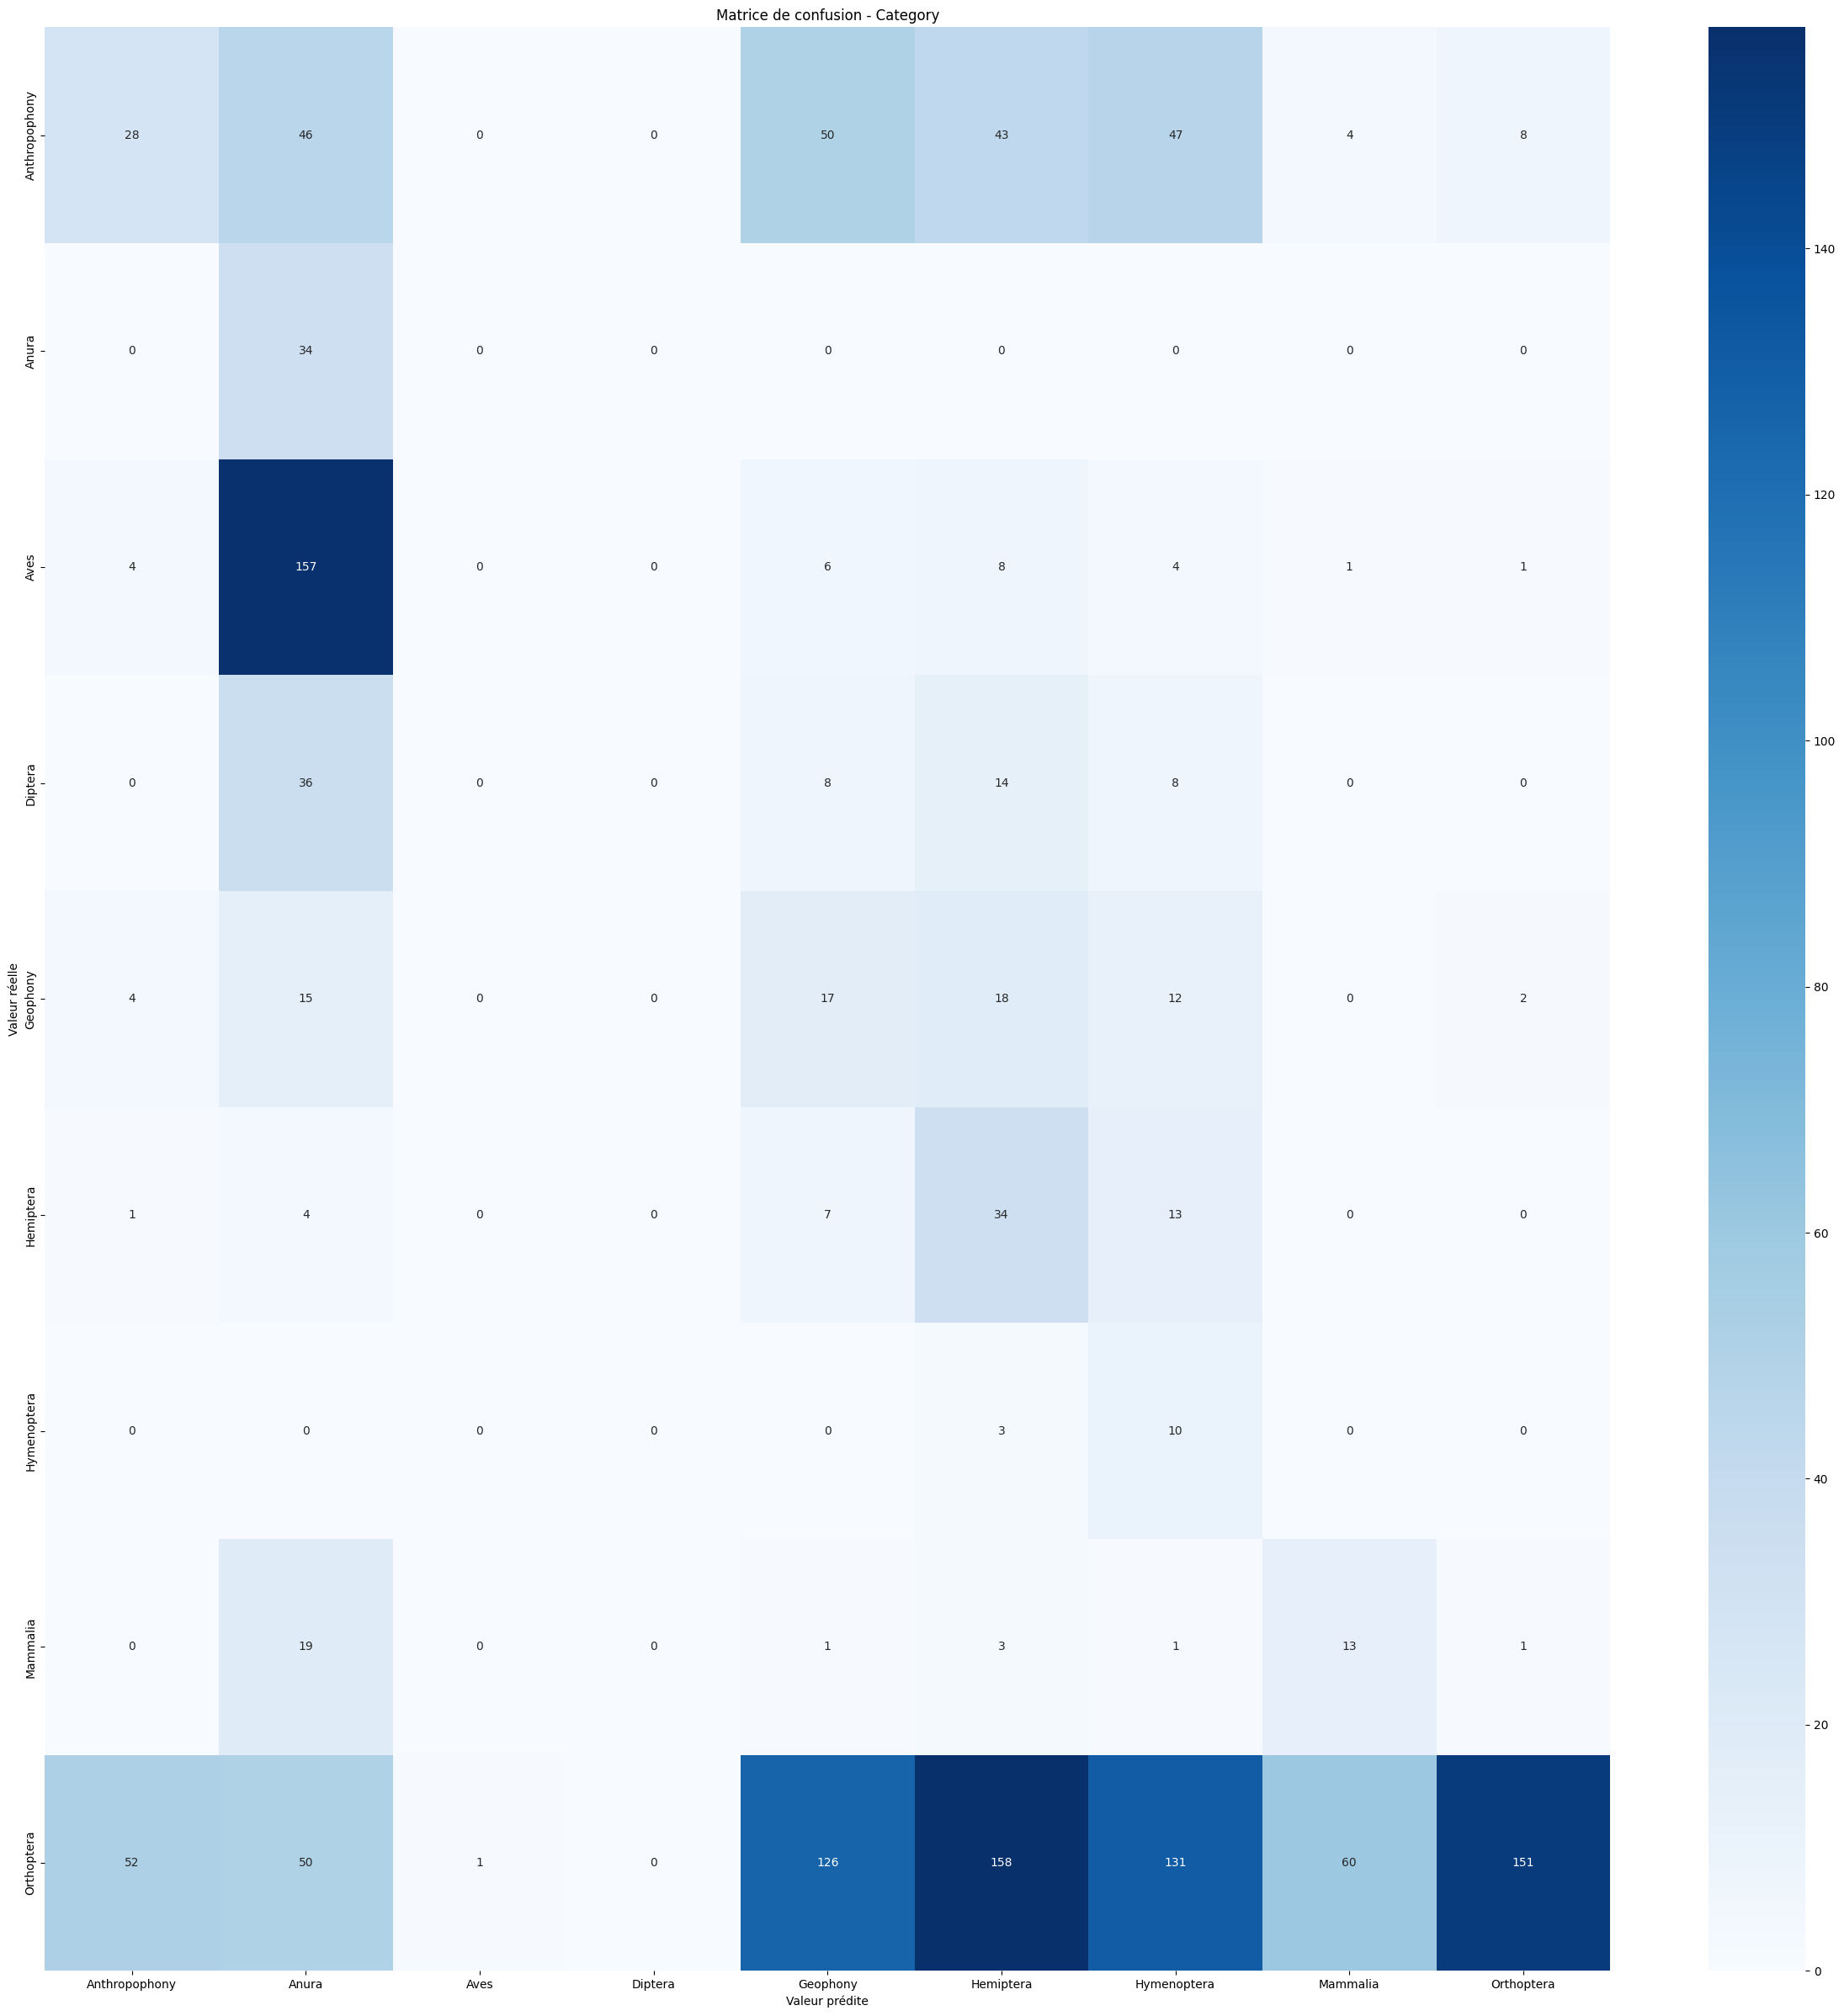

In [49]:
#################### Category ###############################

# Initialiser et entraîner le modèle XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=2)

# Calculer les poids des classes
# 'balanced' ajuste automatiquement les poids inversément proportionnels aux fréquences des classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_category), y=y_train_category)

# Créer un dictionnaire des poids pour faciliter l'application des poids aux échantillons
weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Appliquer les poids aux instances de formation
sample_weight = np.array([weights_dict[y] for y in y_train_category])

# Entraînement du modèle avec les poids des instances
xgb_model.fit(X_train, y_train_category, sample_weight=sample_weight)

predictions_category= xgb_model.predict(X_test)

# Évaluation LightGBM
print("Évaluation LightGBM :")
print("Accuracy sur l'ensemble de validation Category:", accuracy_score(y_test_category, predictions_category))
print(classification_report(y_test_category, predictions_category))

# matrice de confusion
cm = confusion_matrix(y_test_category, predictions_category)
y_test_inversed = label_encoder_category.inverse_transform(y_test_category)

unique_labels = np.unique(y_test_inversed)

plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Matrice de confusion - Category')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.show()